In [2]:
import pandas as pd
from pathlib import Path
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import os.path as osp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,SAGEConv,GATv2Conv,GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch import nn
from torch_geometric.datasets import Entities
import torch
from torch_geometric.datasets import TUDataset
from sklearn.model_selection import KFold
import torch_geometric
import torch
import json
from numpy import random
import torch
import matplotlib.pyplot as plt

In [3]:
torch_geometric.__version__

'2.3.0'

In [4]:
torch.__version__

'2.0.0+cu118'

In [5]:
N_samples=2000
N_rois=116

In [6]:
def generate_syntetic_data(N_samples, N_rois):
    vals = random.standard_normal((N_samples,N_rois, N_rois))
    labels = random.randint(2, size=N_samples)
    for i in range(N_samples):
        if labels[i]==0:
            vals[i,-1,-1] =0.5* random.random_sample()
        else:
            vals[i,-1,-1] =0.5* random.random_sample()+0.5
    for i in range(vals.shape[0]):        
        vals[i, :,:] =(vals[i, :,:] +vals[i, :,:].T)/2        
    return vals, labels        

In [7]:
vals, labels =generate_syntetic_data(N_samples, N_rois)

In [8]:
vals.shape

(2000, 116, 116)

In [9]:
vals[0,2,0]==vals[0,0,2]

True

In [10]:
lr = LogisticRegression(penalty='l1', solver='liblinear')

In [11]:
scores = cross_val_score(lr, vals.reshape(N_samples,-1), labels, cv=5, scoring='accuracy')

In [12]:
np.mean(scores)

0.9495000000000001

In [13]:
def calculate_graph(vals, label):
    X=vals
    #X =np.eye(N_rois,N_rois)
    edge_indexes, edge_attres =[], []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if X[i,j]>0.5:
                edge_indexes.append([i,j])
                edge_attres.append(X[i,j])
    return Data(x=torch.tensor(X), 
                edge_index=torch.tensor(np.array(edge_indexes).T),
                y=torch.tensor([label]))     

In [14]:
## Generate our Synthetic dataset
data_list =[]
for i in range(N_samples):
    data =calculate_graph(vals[i,:,:], labels[i])
    data_list.append(data)

In [15]:
# ## Generate MUTAG dataset

# data_list = TUDataset(root='data/TUDataset', name='MUTAG')

# print()
# print(f'Dataset: {data_list}:')
# print('====================')
# print(f'Number of graphs: {len(data_list)}')
# print(f'Number of features: {data_list.num_features}')
# print(f'Number of classes: {data_list.num_classes}')

In [16]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, N_rois):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GINConv(
                      Sequential(Linear(N_rois, hidden_channels),
                       BatchNorm1d(hidden_channels), ReLU()))
        self.conv2 = GINConv(Sequential(Linear(hidden_channels, hidden_channels),
                       BatchNorm1d(hidden_channels), ReLU()))
        # self.conv1 = GCNConv(N_rois, hidden_channels)
        self.bn1 =BatchNorm1d(hidden_channels)
        # self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 =BatchNorm1d(hidden_channels)
        #self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)
        self.bn3 =BatchNorm1d(hidden_channels)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        #x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index=edge_index)
        x = x.relu()
        x = self.bn1(x)
        
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index=edge_index)
        x = x.relu()
        x = self.bn2(x)

        #x = x.relu()
        #x = self.conv3(x, edge_index)

        # 2. Readout layer
        x_pool = global_max_pool(x, batch)  # [batch_size, hidden_channels]
        
        x = F.dropout(x_pool, p=0.2, training=self.training)
        x =self.bn3(x)

        # 3. Apply a final classifier
        #x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)
        
        return x,x_pool
    
    def compute_l1_loss(self, w):
          return torch.abs(w).sum()


In [17]:
from IPython.display import Javascript

In [18]:
def train(model,train_loader,criterion,optimizer):
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out,x_pool = model(data.x.type(dtype=torch.float).to("cpu"), 
                     data.edge_index.to("cpu"),
                     data.batch.to("cpu"))  # Perform a single forward pass.
         print(out.shape) 
         loss = criterion(out, data.y.to("cpu"))  # Compute the loss.
         # Compute L1 loss component
         l1_weight = 1
         l1_parameters = []
         for parameter in model.parameters():
              l1_parameters.append(parameter.view(-1))
         l1 = l1_weight * model.compute_l1_loss(torch.cat(l1_parameters))
      
      # Add L1 loss component
         loss += l1
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(model,loader):
     model.eval()

     correct = 0
     outs, labels =[], []
     for data in loader:  # Iterate in batches over the training/test dataset.
         out,x_pool = model(data.x.type(dtype=torch.float).to("cpu"), 
                     data.edge_index.to("cpu"),
                     data.batch.to("cpu"))
            
         outs.append(x_pool.detach().cpu().numpy())
         labels.append(data.y.to("cpu").detach().cpu().numpy())
            
         pred = out.argmax(dim=1)  # Use the class with highest probability.
        

         correct += int((pred == data.y.to("cpu")).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset), outs, labels  # Derive ratio of correct predictions.


In [19]:
def run_model(X_train,X_val):
    train_loader = DataLoader(X_train, batch_size=32)
    val_loader = DataLoader(X_val, batch_size=32)
    #test_loader = DataLoader(X_test, batch_size=8)
    
    model = GCN(hidden_channels=32, N_rois =N_rois).to("cpu")
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(1, 100):
        train(model,train_loader,criterion,optimizer)
        train_acc,outs, labels = test(model,train_loader)
        val_acc,outs, labels = test(model,val_loader)
        #test_acc = test(model,test_loader)
    
    return train_acc,val_acc,outs, labels     

In [20]:
train_accs,val_accs, test_accs =[], [], []

num_folds =2
kf = KFold(n_splits=num_folds)

for train_index, valid_index in kf.split(data_list):
    X_train =[data_list[ind] for ind in train_index]
    X_val =[data_list[ind] for ind in valid_index]

    
    labels_train =[elem.y.item() for elem in X_train]
    labels_test =[elem.y.item() for elem in X_val]
    train_acc, val_acc, outs,labels = run_model(X_train,X_val)
    print("Accuracy train: ", train_acc, " val:", val_acc)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    #test_accs.append(test_acc)

torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([8, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])
t

In [21]:
np.mean(train_accs)

0.521

In [22]:
np.std(train_accs)

0.009000000000000008

In [23]:
np.mean(val_accs)

0.521

In [24]:
np.std(val_accs)

0.009000000000000008

In [73]:
#SAGEConv -> 0.736 +-0.138
#GCN -> 0.717 +-0.143
#SAGEConv (dropout) ->0.743+-0.126

In [74]:
## Проверим MUTAG dataset

In [25]:
outs =np.concatenate(outs)

In [26]:
 outs.shape

(1000, 32)

In [27]:
labels =np.concatenate(labels)

In [28]:
outputs_label1 =outs[labels==1]

In [29]:
outputs_label2 =outs[labels==0]

In [30]:
diff =outputs_label1.mean(axis=0) - outputs_label2.mean(axis=0)

In [31]:
diff

array([-6.54836185e-11,  0.00000000e+00, -4.36557457e-11,  5.82076609e-11,
        1.09139364e-11,  1.81898940e-12,  1.27329258e-11, -1.52795110e-10,
       -1.45519152e-11, -7.27595761e-12,  2.18278728e-11, -2.91038305e-11,
        2.91038305e-11, -1.09139364e-10, -1.52795110e-10,  0.00000000e+00,
        0.00000000e+00,  1.38243195e-10, -7.27595761e-12,  8.00355338e-11,
       -2.91038305e-11, -1.23691279e-10,  1.52795110e-10, -1.81898940e-12,
        0.00000000e+00,  0.00000000e+00,  7.27595761e-11, -1.30967237e-10,
       -1.01863407e-10,  5.82076609e-11, -2.18278728e-11,  0.00000000e+00],
      dtype=float32)

In [32]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

<AxesSubplot:>

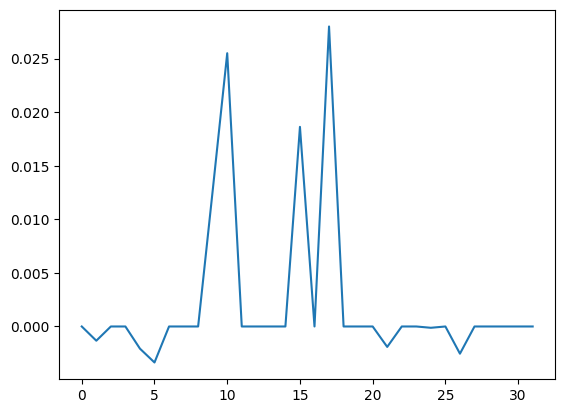

In [ ]:
sns.lineplot(data=diff)

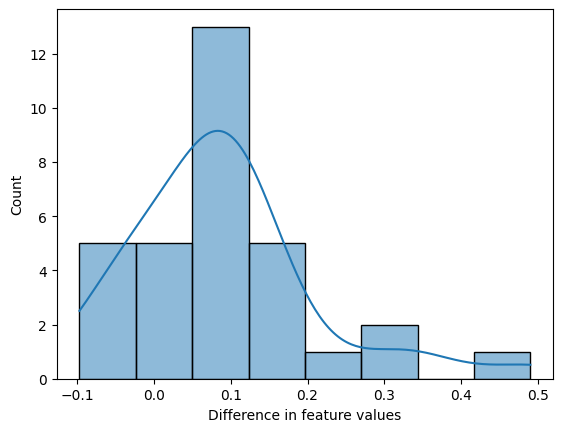

In [ ]:
sns.histplot(diff, kde=True)
plt.xlabel('Difference in feature values')
plt.ylabel('Count')
plt.show()